In [2]:
import os, torch, torch.nn as nn, torch.optim as optim
from PIL import Image

from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

import random, copy, matplotlib.pyplot as plt, numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from datetime import datetime

In [13]:
path = os.path.join(os.getcwd(), "C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder")

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_14600\1025717281.py:1: SyntaxWarning: invalid escape sequence '\M'
  path = os.path.join(os.getcwd(), "C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder")


In [4]:
obj_dt = datasets.ImageFolder(path, transform=transforms.ToTensor())
dataloader = DataLoader(obj_dt, batch_size=64, shuffle=False, num_workers=4)

In [5]:
mean = torch.zeros(3)
std = torch.zeros(3)

In [6]:
for images, _ in dataloader:
    for d in range(3):
        mean[d] += images[:, d, :, :].mean()
        std[d] += images[:, d, :, :].std()

mean.div_(len(obj_dt))
std.div_(len(obj_dt))

tensor([0.0046, 0.0046, 0.0054])

In [7]:
print(f'Mean : ', mean)
print(f'Std : ', std)

Mean :  tensor([0.0091, 0.0094, 0.0080])
Std :  tensor([0.0046, 0.0046, 0.0054])


In [8]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val' : transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [9]:
directory = 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder'

img_dt = {
    'train' : datasets.ImageFolder(os.path.join(directory, 'train'), data_transforms['train']),
    'test' : datasets.ImageFolder(os.path.join(directory, 'test'), data_transforms['test']),
    'val' : datasets.ImageFolder(os.path.join(directory, 'val'), data_transforms['val'])
}

dataloaders = {
    'train' : DataLoader(img_dt['train'], batch_size=16, shuffle=True, num_workers=2),
    'test' : DataLoader(img_dt['test'], batch_size=16, shuffle=True, num_workers=2),
    'val' : DataLoader(img_dt['val'], batch_size=16, shuffle=True, num_workers=2)
}

dt_sizes = {x: len(img_dt[x]) for x in ['train', 'test', 'val']}
class_names = img_dt['train'].classes

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\MyBook Hype AMD\AppData\Local\Temp\ipykernel_14600\2562457351.py:1: SyntaxWarning: invalid escape sequence '\M'
  directory = 'C:\Mbudhi\Kuliah\Program\CNN_Augmented.v2-alexnet_227x227_612pics_2025-03-15-1-16pm.folder'


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = models.alexnet(pretrained=True)
model.eval()
model = model.to(device)

c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [15]:
# Add this before training to verify model setup
print("Model configuration:")
print(model)
print("\nDevice:", device)
print("Memory allocated:", torch.cuda.memory_allocated() if torch.cuda.is_available() else "CPU")

Model configuration:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

In [17]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Starting Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
        print(f'Starting {phase} phase')
        try:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f'Processing batch {batch_idx}')
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dt_sizes[phase]
            epoch_acc = running_corrects.double() / dt_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:  # validation
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        except Exception as e:
            print(f"Error in {phase} phase: {str(e)}")
            raise e

Starting Epoch 1/10
----------
Starting train phase
Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4
Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12
Processing batch 13
Processing batch 14
Processing batch 15
Processing batch 16
Processing batch 17
Processing batch 18
Processing batch 19
Processing batch 20
Processing batch 21
Processing batch 22
Processing batch 23
Processing batch 24
Processing batch 25
Processing batch 26
Processing batch 27
Processing batch 28
Processing batch 29
Processing batch 30
Processing batch 31
Processing batch 32
Processing batch 33
train Loss: 11.6985 Acc: 0.2004
Starting val phase
Processing batch 0
Processing batch 1
Processing batch 2
val Loss: 1.6637 Acc: 0.1471
Starting Epoch 2/10
----------
Starting train phase
Processing batch 0
Processing batch 1
Processing batch 2
Processing batch 3
Processing ba

In [18]:
model.load_state_dict(best_model_wts)

date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
training_note = "alex_daun"

model_save_path = f"{training_note}_{date}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to alex_daun_2025-05-05_14-37-18.pth


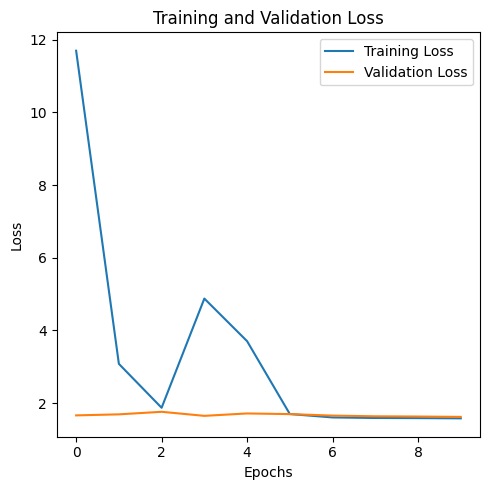

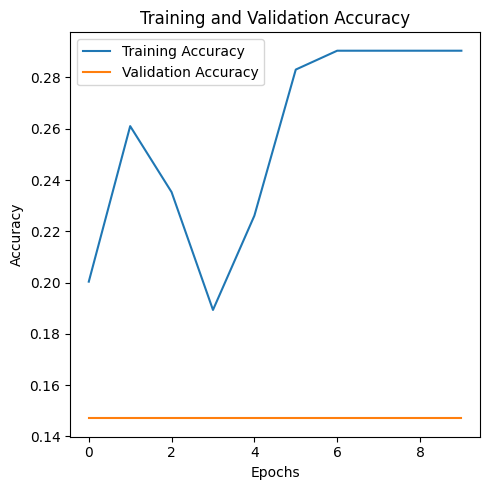

In [ ]:
def plot_loss(train_loss, val_loss, save=True):
    plt.figure(figsize=(5, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()

    if save:
        os.makedirs('./training_stat', exist_ok=True)

        plt.savefig(f'./training_stat/loss_plot_{training_note}_{date}.png')

    plt.show()

def plot_accuracy(train_acc, val_acc, save=True):
    plt.figure(figsize=(5, 5))
    plt.plot([x.cpu().numpy() for x in train_acc], label='Training Accuracy')
    plt.plot([x.cpu().numpy() for x in val_acc], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.tight_layout()

    if save:
        os.makedirs('./training_stat', exist_ok=True)

        plt.savefig(f'./training_stat/accuracy_plot_{training_note}_{date}.png')

    plt.show()

plot_loss(train_losses, val_losses)
plot_accuracy(train_accs, val_accs)

In [20]:
model.load_state_dict(torch.load(model_save_path))
model = model.to(device)
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
correct = 0
total = 0

all_labels = []
predictions = []

In [27]:
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print(f'Total data to test : ' + str(total))
print(f'Total data correct : ' + str(correct))
print(f'Accuracy : {accuracy:.2f}%')

Total data to test : 34
Total data correct : 0
Accuracy : 0.00%


In [29]:
# Convert predictions to match the actual class indices
predictions = [p % len(class_names) for p in predictions]

print(classification_report(all_labels, predictions, target_names=class_names))

                 precision    recall  f1-score   support

    bercak_daun       0.23      1.00      0.38         7
  daun_berkerut       0.67      0.18      0.29        11
  daun_berputar       0.00      0.00      0.00         5
daun_menggulung       0.00      0.00      0.00         4
 daun_menguning       0.00      0.00      0.00         7

       accuracy                           0.26        34
      macro avg       0.18      0.24      0.13        34
   weighted avg       0.26      0.26      0.17        34



c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MyBook Hype AMD\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh